<a href="https://colab.research.google.com/github/ubsuny/PHY386/blob/Homework2025/2025/HW/iamtomato761/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Processing


In [74]:
# prompt: read in csv file using pandas
# remove beginning and end of data where experiment didn't start yet / was already over

import pandas as pd

# Assuming your CSV file is named 'your_file.csv'
df = pd.read_csv('/content/acceleration.csv')

# starting index
total_rows = len(df)
start_index = 2200

# ending index
end_index = 4494

# Slice the dataframe to remove the unwanted rows
df_processed = df.iloc[start_index : end_index + 1]

# Now df_processed contains only the relevant data
df_processed


,Time (s),Linear Acceleration x (m/s^2),Linear Acceleration y (m/s^2),Linear Acceleration z (m/s^2),Absolute acceleration (m/s^2)
2200,10.711173,1.488338,2.836539,-1.916385,3.732779
2201,10.716020,1.472064,2.796924,-1.950084,3.713837
2202,10.720868,1.453862,2.739449,-1.987013,3.683275
2203,10.725715,1.428822,2.709374,-2.029476,3.674373
2204,10.730562,1.415830,2.639982,-2.032270,3.619973
...,...,...,...,...,...
4490,21.811743,-0.716845,1.590611,-1.365550,2.215544
4491,21.816590,-0.697325,1.586576,-1.402787,2.229641
4492,21.821438,-0.679469,1.549844,-1.450389,2.228749
4493,21.826285,-0.660757,1.523394,-1.467898,2.216316


# Model Fitting



## plot

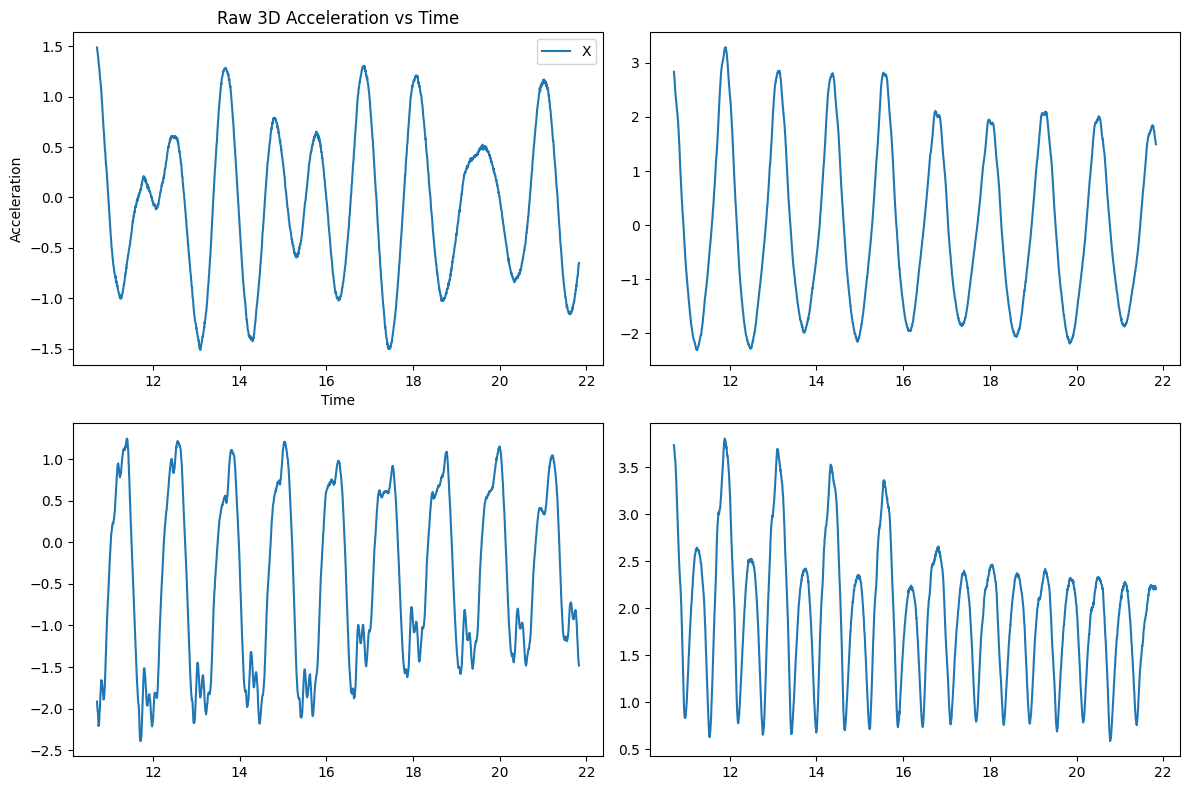

In [76]:
# prompt: Create a 2x2 subplot grid containing:
# Raw 3D acceleration vs time

import matplotlib.pyplot as plt
import pandas as pd

# Load the processed data
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Raw 3D acceleration vs time
axs[0, 0].plot(df_processed['Time (s)'], df_processed['Linear Acceleration x (m/s^2)'], label='X')
axs[0, 1].plot(df_processed['Time (s)'], df_processed['Linear Acceleration y (m/s^2)'], label='Y')
axs[1, 0].plot(df_processed['Time (s)'], df_processed['Linear Acceleration z (m/s^2)'], label='Z')
axs[1, 1].plot(df_processed['Time (s)'], df_processed['Absolute acceleration (m/s^2)'], label='Absolute')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Acceleration')
axs[0, 0].set_title('Raw 3D Acceleration vs Time')
axs[0, 0].legend()


plt.tight_layout()
plt.show()


This isn't the 2x2 shared axes, but I'm commiting what I have so far